# Shap Study

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. [Github Link](https://github.com/slundberg/shap).

In [1]:
import logging
logger = logging.getLogger('')
logger.setLevel(logging.INFO)

from wax_toolbox import Timer
from churnchall.boosters import LgbCookie, get_df_importance

import shap
# load JS visualization code to notebook
shap.initjs()


# Plots purpose:
from plotlyink import register_pandas_iplot_accessor
register_pandas_iplot_accessor()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
import pandas as pd
import numpy as np

m = LgbCookie(debug=False)

/Users/jd5584/miniconda3/envs/ml/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Data Exploration

In [2]:
dfdescr = pd.read_excel('../data/description_variables.xlsx')
pd.options.display.max_colwidth = 150
dfdescr

Variable name  \
0                          cible   
1                 Echéance.Année   
2                  Echéance.Mois   
3                        Produit   
4                          Durée   
5                   Type.d.offre   
6                   Type.de.prix   
7                 Canal.de.vente   
8                           Zone   
9                Marché.de.la.SC   
10  Segment.société.contractante   
11   Entité.société.contractante   
12                    Profil.PRM   
13            Couleur.Tarif.Elec   
14                 Volume_annuel   
15                     nb_dem_12   
16                   nb_recla_12   
17                nb_dem_reco_12   
18              nb_recla_reco_12   
19                   type_client   
20                   libellé_NAF   
21                  activité_NCE   
22             ancienneté_client   
23                   Prix_Gaz_M3   
24                  Prix_Elec_M3   

                                         Variable           Type  \
0                               output to predict    qualitative   
1                         contract's due date year  quantitative   
2                        contract's due date month  quantitative   
3                                          product   qualitative   
4                           length of the contract  quantitative   
5                                            offer   qualitative   
6                                          pricing   qualitative   
7                                    sales channel   qualitative   
8                                geographical zone   qualitative   
9                                           market   qualitative   
10                                    segmentation   qualitative   
11                                    sales entity   qualitative   
12                             consumption profile   qualitative   
13                       consumption power profile   qualitative   
14                                   annual volume  quantitative   
15    number of requests within the last 12 months  quantitative   
16  number of complaints within the last 12 months  quantitative   
17    number of requests within the last 12 months  quantitative   
18  number of complaints within the last 12 months  quantitative   
19                                  type of client   qualitative   
20                      client activity (NAF code)   qualitative   
21                      client activity (NCE code)   qualitative   
22                                client seniority  quantitative   
23          gaz price 3 months before the due date  quantitative   
24        power price 3 months before the due date  quantitative   

                                                                                                                                              Description  
0                                                                  binary variable : if 0, the contract was terminated. If 1, the contract has continued.  
1                                                                                                                   Due date's year of the tacit contract  
2                                                                                                                  Due date's month of the tacit contract  
3                                                                                                                                            power or gas  
4                                          The tacit contract can be terminated or pursued at the end of the contract. Usual lengths are 1, 2 or 3 years.  
5                                                                                                individual pricing or offer based on a calculation table  
6                                                                                                              fixed price or price related to the market  
7                                                                

In [3]:
dftrain, dftest = m.get_train_valid_set()
X, y = dftrain

print("Training set shape: {}".format(X.shape))

modelsaved = 'lightgbm_model_21-20h-10m.txt'
booster = lgb.Booster(model_file='../results/model_bank/{}'.format(modelsaved))

train = pd.concat((X, y), axis=1)
colormap = plt.cm.RdBu

Reading train set took 0.112 sec
Training set shape: (285335, 35)


In [4]:
dfimp = get_df_importance(booster)
top_imp_cols = dfimp.head(10).columns.tolist()
dfimp.head(10)

importance
Volume_annuel                   11.672199
ancienneté_client               11.032085
Prix_Elec_M3                     7.511459
Dep_Moyenne_Salaires_Horaires    7.191402
Prix_Gaz_M3                      7.116327
Nb_Logement                      4.488699
Nb_Atifs                         4.370160
libellé_NAF                      3.998736
Nb_propriétaire                  3.990833
Echéance.Mois                    3.896001

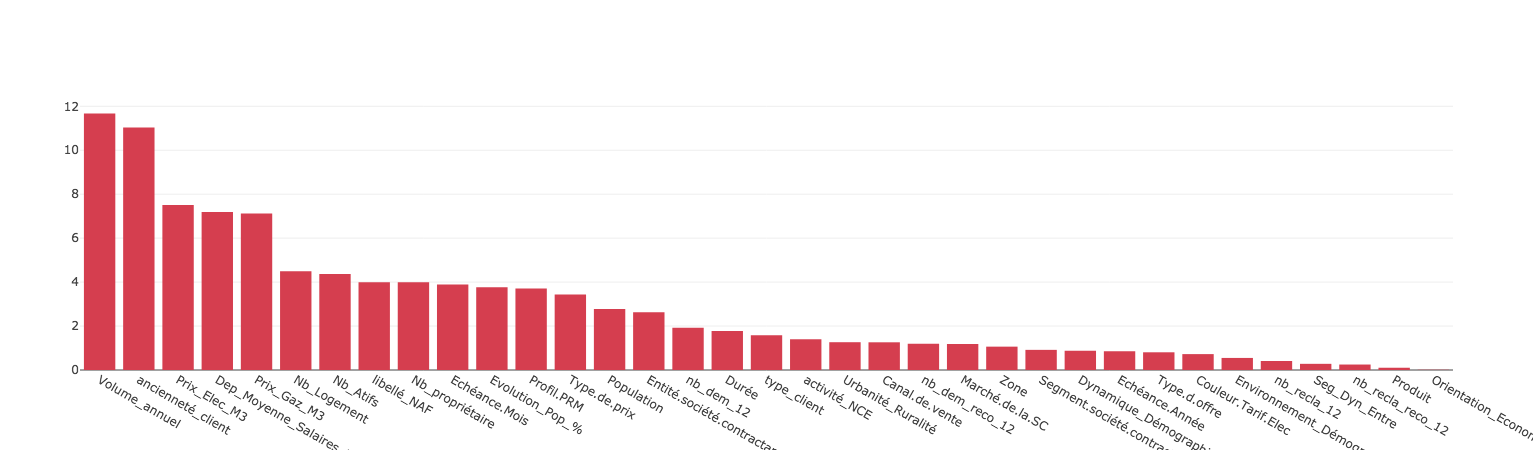

In [5]:
dfimp.iplot.bar()

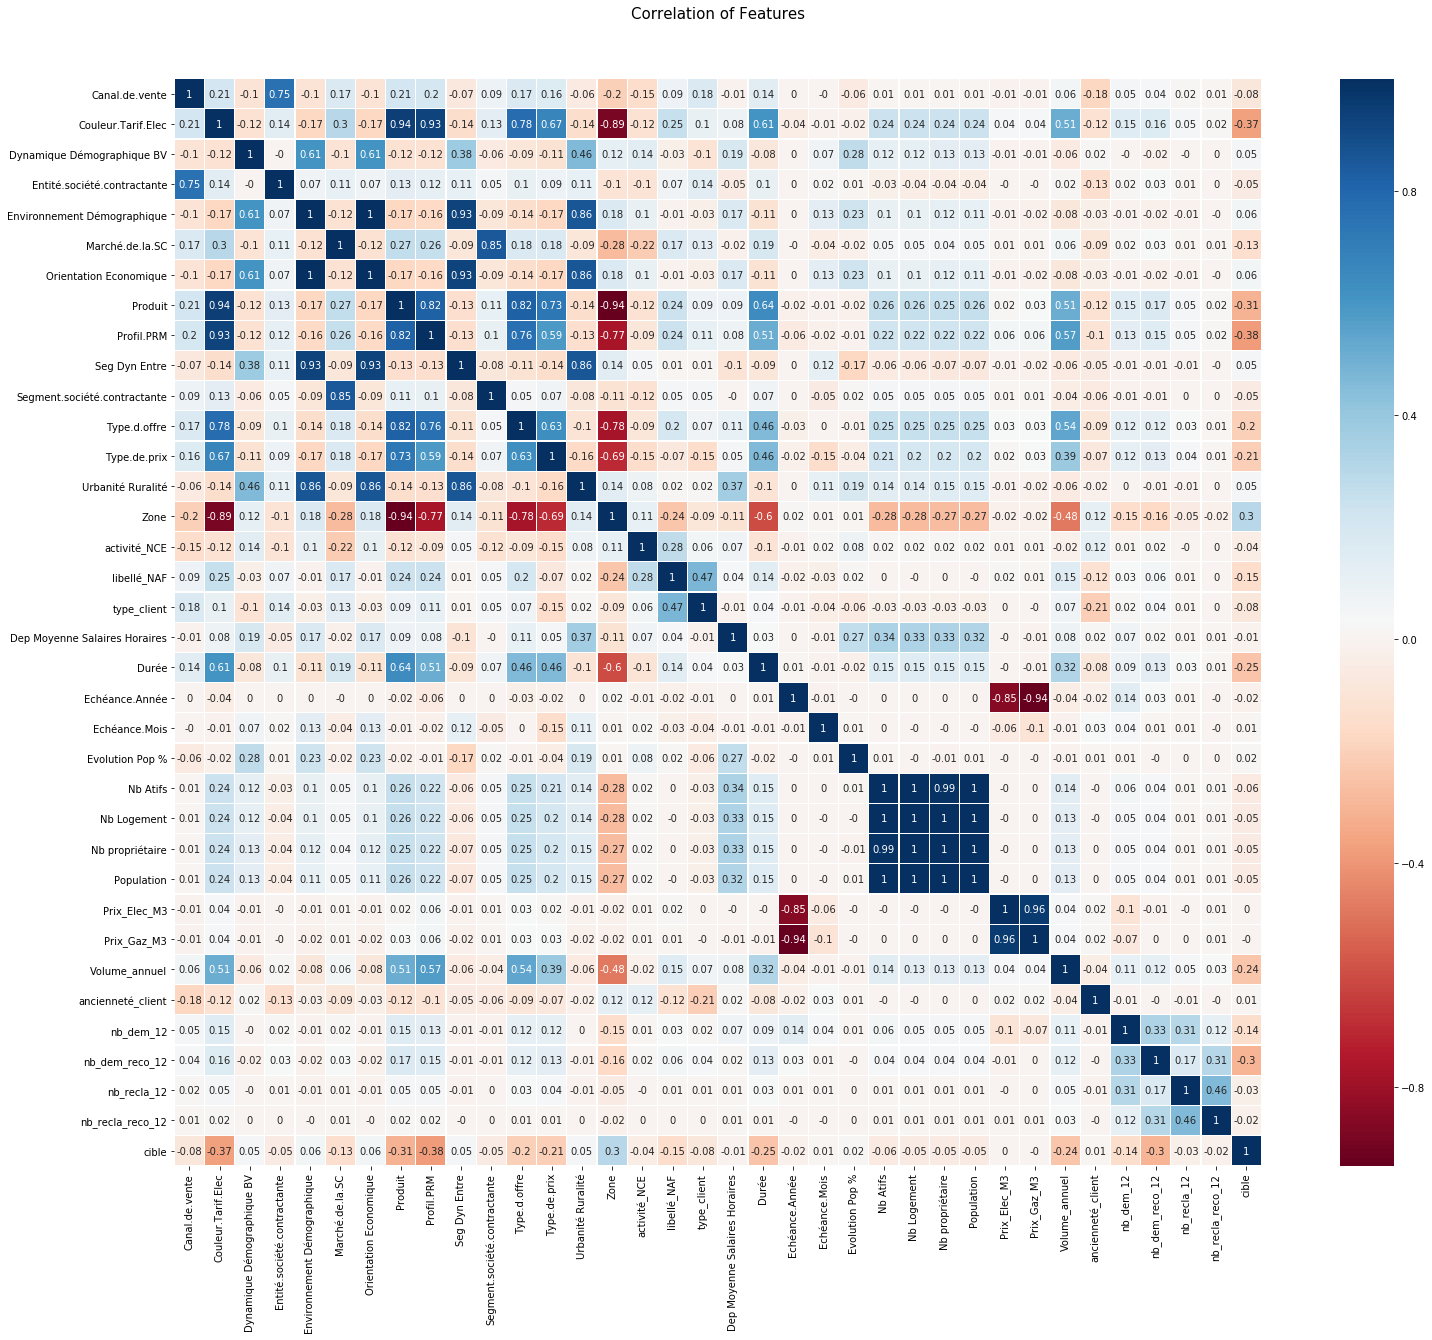

In [6]:

plt.figure(figsize=(28,20))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr().round(2),
            linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

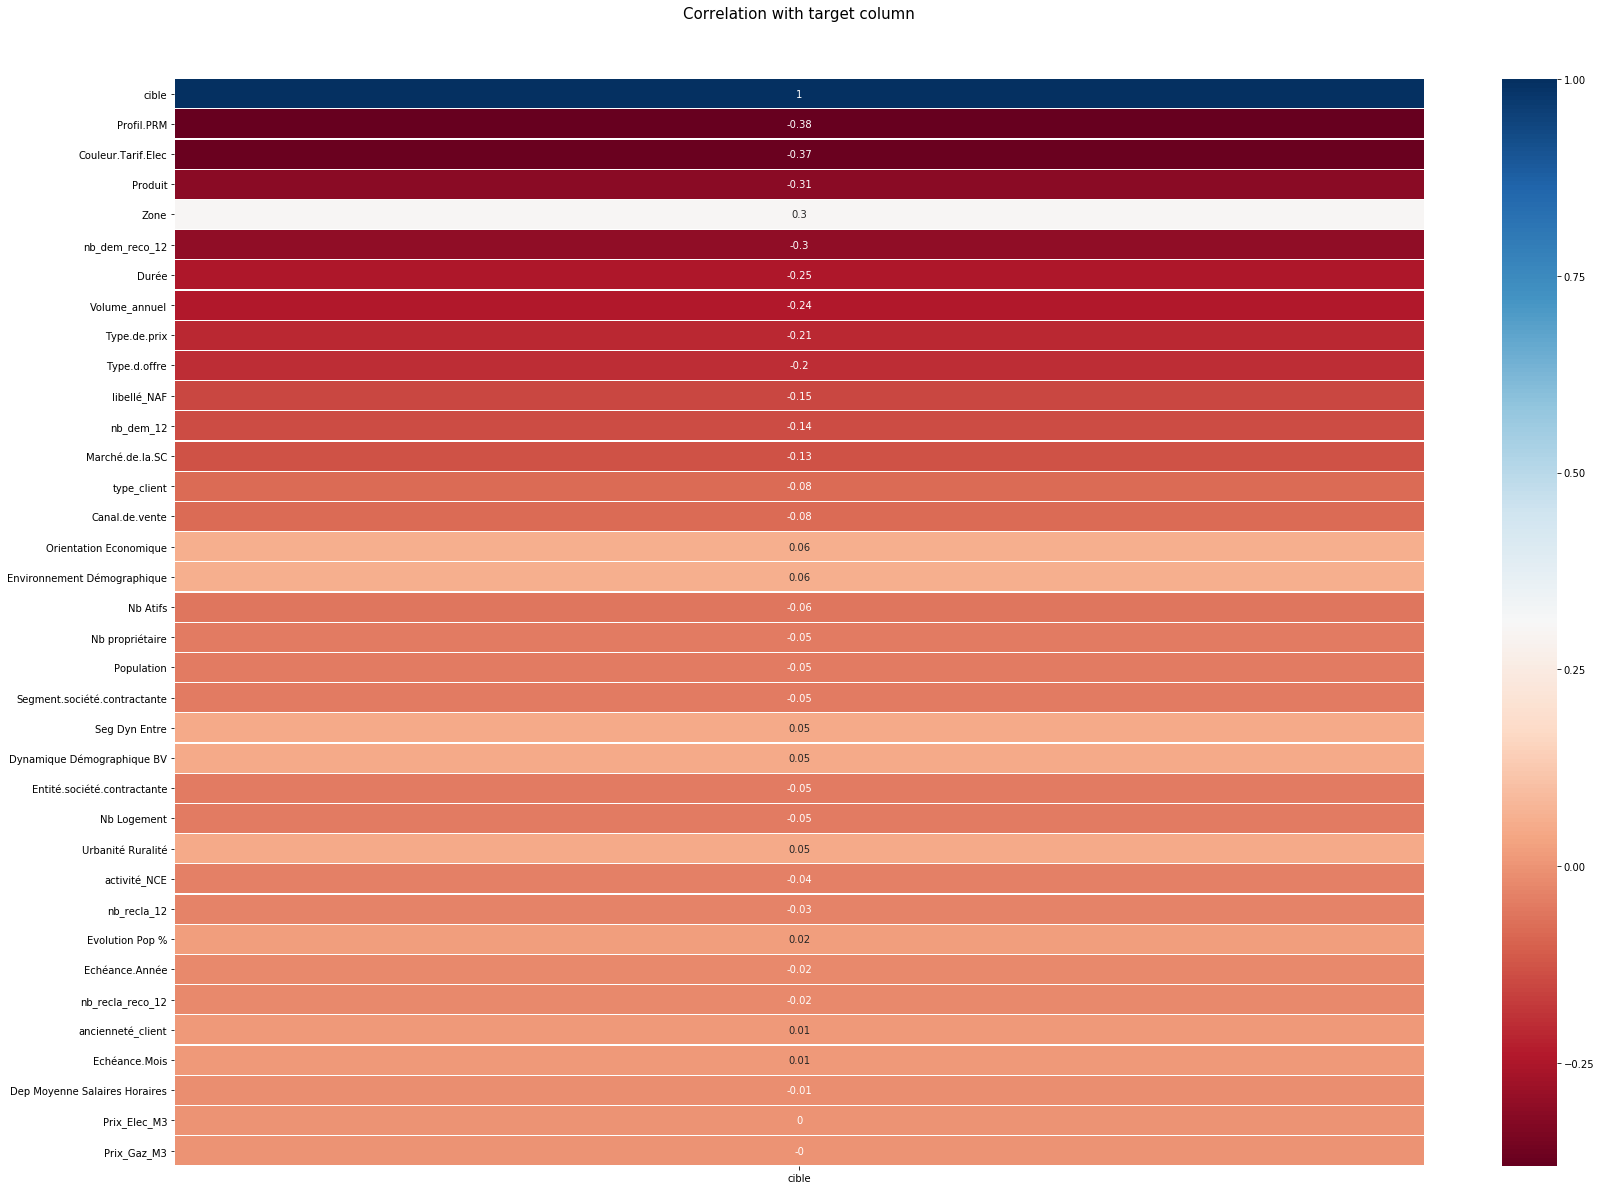

In [7]:
plt.figure(figsize=(28,20))
plt.title('Correlation with target column', y=1.05, size=15)
dfplot = train.astype(float).corr().round(2)[['cible']]
dfplot['abs'] = dfplot['cible'].abs()
dfplot = dfplot.sort_values('abs', ascending=False)

dfplot = dfplot.drop(columns=['abs'])
top_corr_cols = dfplot.iloc[:10].index.tolist()

sns.heatmap(dfplot,
            linewidths=0.1, vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=True)

## Sharp

In [8]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(booster)

In [9]:
#with Timer('Running Shap explainer on X', at_enter=True):
#    shap_values = explainer.shap_values(X)

#Running Shap explainer on X in progress...
#Running Shap explainer on X took 235.743 sec

fname = '../results/shap_explainer.npy'
#np.save(fname, shap_values)

shap_values = np.load(fname)

In [10]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [ ]:
#with Timer('visualize all the training set predictions', at_enter=True):
#    shap.force_plot(explainer.expected_value, shap_values, X)

SHAP dependence plot to show the effect of a single feature across the whole dataset in progress...


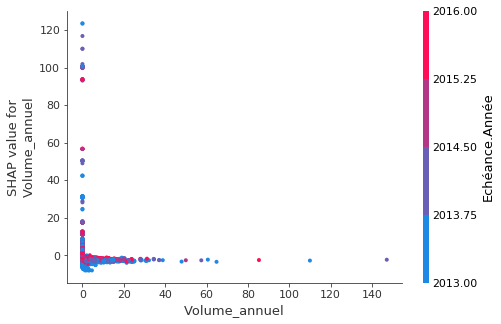

SHAP dependence plot to show the effect of a single feature across the whole dataset took 4.574 sec


In [11]:
with Timer('SHAP dependence plot to show the effect of a single feature across the whole dataset', at_enter=True):
    shap.dependence_plot("Volume_annuel", shap_values, X)

summarize the effects of all the features in progress...


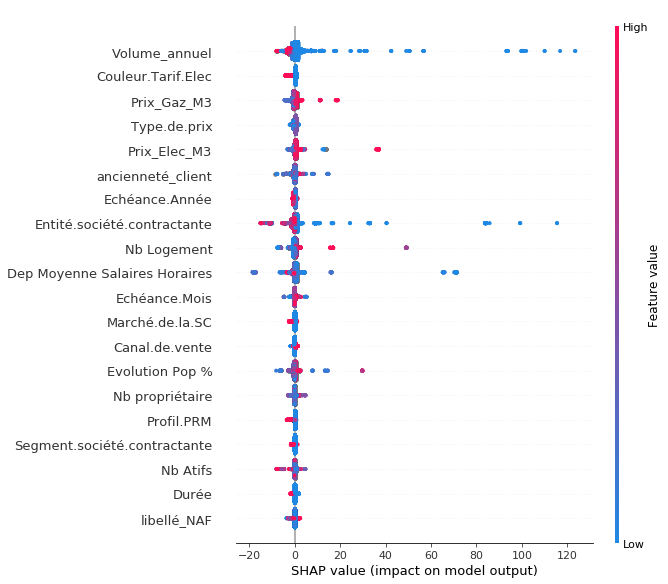

summarize the effects of all the features took 85.807 sec


In [12]:
with Timer('summarize the effects of all the features', at_enter=True):
    shap.summary_plot(shap_values, X)